# NIH Few-Shot (One-Shot) Classification with MedCLIP

This notebook fine-tunes a lightweight linear head on top of a frozen MedCLIP image encoder using one/few-shot samples per class and evaluates on the held-out test split generated earlier.

In [1]:
# ========= 1) Setup & Config =========
import os
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display

from medclip import MedCLIPModel, MedCLIPProcessor
from medclip.modeling_medclip import SuperviseClassifier

# Prefer Apple Silicon GPU or CUDA when available
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

THIS_DIR = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd().resolve()
TRAIN_CSV = (THIS_DIR / "local_data" / "nih-sampled-meta-train.csv").resolve()
TEST_CSV = (THIS_DIR / "local_data" / "nih-sampled-meta-test.csv").resolve()
IMAGE_ROOT = THIS_DIR  # imgpath column already stores repo-relative paths

CHEXPERT5 = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]

VISION_MODEL = "vit"                      # or "resnet"
SHOT_PER_CLASS = 100                          # one-shot by default; increase (e.g., 5) for few-shot
BATCH_SIZE = 4
NUM_EPOCHS = 50
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
RANDOM_STATE = 42

print("Torch:", torch.__version__)
print("Device:", DEVICE)
print("Train CSV:", TRAIN_CSV)
print("Test  CSV:", TEST_CSV)


/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/

Torch: 2.5.1
Device: mps
Train CSV: /Users/zitongluo/Library/Mobile Documents/com~apple~CloudDocs/硕士相关/2025Fall/Learning from small data/MedCLIP_eval/local_data/nih-sampled-meta-train.csv
Test  CSV: /Users/zitongluo/Library/Mobile Documents/com~apple~CloudDocs/硕士相关/2025Fall/Learning from small data/MedCLIP_eval/local_data/nih-sampled-meta-test.csv


In [2]:
# ========= 2) Load train/test metadata =========
def resolve_path(p: str) -> Path:
    raw = Path(p)
    return raw.resolve() if raw.is_absolute() else (IMAGE_ROOT / raw).resolve()

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

for name, df in (("train", train_df), ("test", test_df)):
    if "disease" not in df.columns or "imgpath" not in df.columns:
        raise KeyError(f"{name} CSV must contain 'disease' and 'imgpath' columns.")
    df["disease"] = df["disease"].astype(str)
    df["img_abs_path"] = df["imgpath"].apply(lambda p: str(resolve_path(p)))
    exists = df["img_abs_path"].apply(lambda p: Path(p).exists())
    missing = len(df) - exists.sum()
    if missing:
        print(f"[WARN] {missing} files missing in {name} split; they will be dropped.")
        display(df.loc[~exists, ["Image Index", "img_abs_path"]].head(10))
    df.drop(index=df.index[~exists], inplace=True)
    df.reset_index(drop=True, inplace=True)

# Keep disease-only five-class subset
train_df = train_df.loc[train_df["disease"].isin(CHEXPERT5)].reset_index(drop=True)
test_df = test_df.loc[test_df["disease"].isin(CHEXPERT5)].reset_index(drop=True)

print("Train size after filtering:", len(train_df))
print(train_df["disease"].value_counts().sort_index())
print("Test size after filtering:", len(test_df))
print(test_df["disease"].value_counts().sort_index())


Train size after filtering: 2000
disease
Atelectasis         400
Cardiomegaly        400
Consolidation       400
Edema               400
Pleural Effusion    400
Name: count, dtype: int64
Test size after filtering: 5000
disease
Atelectasis         1000
Cardiomegaly        1000
Consolidation       1000
Edema               1000
Pleural Effusion    1000
Name: count, dtype: int64


In [6]:
# ========= 3) Sample one/few-shot training subset =========
def build_few_shot(df: pd.DataFrame, shots: int, seed: int) -> pd.DataFrame:
    if shots < 1:
        raise ValueError("shots must be >= 1")
    sampled_frames = []
    for label, group in df.groupby("disease"):
        take = min(shots, len(group))
        sampled = group.sample(n=take, random_state=seed, replace=False)
        sampled_frames.append(sampled)
    few = pd.concat(sampled_frames, ignore_index=True)
    few = few.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return few

few_shot_train_df = build_few_shot(train_df, SHOT_PER_CLASS, RANDOM_STATE)
if few_shot_train_df.empty:
    raise RuntimeError("Few-shot training set is empty; check SHOT_PER_CLASS and data filtering.")

print("Few-shot train size:", len(few_shot_train_df))
print(few_shot_train_df["disease"].value_counts().sort_index())


Few-shot train size: 500
disease
Atelectasis         100
Cardiomegaly        100
Consolidation       100
Edema               100
Pleural Effusion    100
Name: count, dtype: int64


In [7]:
# ========= 4) Dataset & Dataloader helpers =========
class NIHSingleLabelDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, class_to_idx: Dict[str, int], processor: MedCLIPProcessor):
        self.df = dataframe.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.processor = processor

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        with Image.open(row["img_abs_path"]) as img:
            image = img.convert("RGB")
        processed = self.processor(images=image, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)
        label_idx = self.class_to_idx[row["disease"]]
        return {
            "pixel_values": pixel_values,
            "label": torch.tensor(label_idx, dtype=torch.long),
            "path": row["img_abs_path"],
        }

def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    paths = [item["path"] for item in batch]
    return {"pixel_values": pixel_values, "labels": labels, "paths": paths}

processor = MedCLIPProcessor()

CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CHEXPERT5)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

train_dataset = NIHSingleLabelDataset(few_shot_train_df, CLASS_TO_IDX, processor)
test_dataset = NIHSingleLabelDataset(test_df, CLASS_TO_IDX, processor)

train_batch_size = max(1, min(BATCH_SIZE, len(train_dataset)))
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("Train samples:", len(train_dataset), "| Batches:", len(train_loader))
print("Test samples:", len(test_dataset), "| Batches:", len(test_loader))


/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Train samples: 500 | Batches: 125
Test samples: 5000 | Batches: 1250


In [8]:
# ========= 3–7) Sweep 多个 shots & 可视化 =========
import matplotlib.pyplot as plt

# 固定的 shots 列表与 zero-shot 基线
SHOTS_GRID = [1, 5, 10, 20, 30, 50, 70, 100, 150, 200]
BASELINE_ZERO_SHOT = 0.529  # 给定的 zero-shot accuracy

# ========= Dataset & Dataloader（复用你前面定义的 Dataset/Processor/CLASS_TO_IDX 等）=========
# 保留你前面定义的：
# - build_few_shot()
# - NIHSingleLabelDataset
# - collate_fn
# - processor = MedCLIPProcessor()
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CHEXPERT5)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

# 测试集只构建一次
test_dataset = NIHSingleLabelDataset(test_df, CLASS_TO_IDX, processor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ========= 5) 仅加载一次视觉主干（冻结）=========
base_model = MedCLIPModel.from_pretrained(vision_model=VISION_MODEL, device=DEVICE)
vision_encoder = base_model.vision_model
vision_encoder.to(DEVICE)
setattr(vision_encoder, "device", torch.device(DEVICE))  # 某些版本的 medclip 需要
for p in vision_encoder.parameters():
    p.requires_grad = False
vision_encoder.eval()

classifier_input_dim = 768 if VISION_MODEL == "vit" else 512

def predict_logits(dataloader, head):
    head.eval()
    head.model.eval()
    logits_list, labels_list = [], []
    with torch.no_grad():
        for batch in dataloader:
            pv = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            out = head(pixel_values=pv, labels=None, return_loss=False)
            logits_list.append(out["logits"].detach().cpu())
            labels_list.append(labels.detach().cpu())
    if not logits_list:
        return np.empty((0, len(CHEXPERT5))), np.empty((0,), dtype=int)
    logits = torch.cat(logits_list, dim=0).numpy()
    labels = torch.cat(labels_list, dim=0).numpy()
    return logits, labels

def train_and_eval_for_shots(shots: int, seed: int = RANDOM_STATE) -> float:
    """仅训练线性头，返回该 shots 下的 Test accuracy。"""
    few_df = build_few_shot(train_df, shots, seed)
    if few_df.empty:
        print(f"[WARN] shots={shots} 训练集为空，跳过。")
        return float("nan")

    train_dataset = NIHSingleLabelDataset(few_df, CLASS_TO_IDX, processor)
    train_loader = DataLoader(
        train_dataset,
        batch_size=max(1, min(BATCH_SIZE, len(train_dataset))),
        shuffle=True,
        collate_fn=collate_fn
    )

    # 新建一个 SuperviseClassifier（共享冻结后的 vision_encoder，每次重置线性层）
    head = SuperviseClassifier(
        vision_model=vision_encoder,
        num_class=len(CHEXPERT5),
        input_dim=classifier_input_dim,
        mode="multiclass",
    ).to(DEVICE)

    # 冻结主干，只训练 fc
    for param in head.model.parameters():
        param.requires_grad = False
    head.model.eval()
    head.fc.reset_parameters()

    optimizer = torch.optim.Adam(head.fc.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    torch.manual_seed(seed)
    if DEVICE == "cuda":
        torch.cuda.manual_seed_all(seed)

    # 线性头训练
    for epoch in range(1, NUM_EPOCHS + 1):
        head.train()
        head.model.eval()  # backbone 仍保持 eval
        for batch in train_loader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            optimizer.zero_grad()
            outputs = head(pixel_values=pixel_values, labels=labels, return_loss=True)
            loss = outputs["loss_value"]
            loss.backward()
            optimizer.step()

    # Test 评估
    logits, labels = predict_logits(test_loader, head)
    if logits.shape[0] == 0:
        print(f"[WARN] shots={shots} 无法评估（logits 为空）。")
        return float("nan")
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    print(f"shots={shots:>3d} | Test accuracy = {acc:.4f} (n={len(labels)})")
    return float(acc)

# ========= 6) 执行 sweep，收集结果 =========
results = []
for shots in SHOTS_GRID:
    acc = train_and_eval_for_shots(shots)
    results.append({"shots": shots, "test_accuracy": acc})

acc_df = pd.DataFrame(results).sort_values("shots").reset_index(drop=True)
display(acc_df)

/opt/homebrew/Caskroom/miniforge/base/envs/medclip_eval/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

Model moved to mps
load model weight from: pretrained/medclip-vit
shots=  1 | Test accuracy = 0.3492 (n=5000)
shots=  5 | Test accuracy = 0.4804 (n=5000)
shots= 10 | Test accuracy = 0.5118 (n=5000)
shots= 20 | Test accuracy = 0.5326 (n=5000)
shots= 30 | Test accuracy = 0.5308 (n=5000)
shots= 50 | Test accuracy = 0.5450 (n=5000)
shots= 70 | Test accuracy = 0.5446 (n=5000)
shots=100 | Test accuracy = 0.5548 (n=5000)
shots=150 | Test accuracy = 0.5554 (n=5000)
shots=200 | Test accuracy = 0.5698 (n=5000)


,shots,test_accuracy
0,1,0.3492
1,5,0.4804
2,10,0.5118
3,20,0.5326
4,30,0.5308
5,50,0.5450
6,70,0.5446
7,100,0.5548
8,150,0.5554
9,200,0.5698


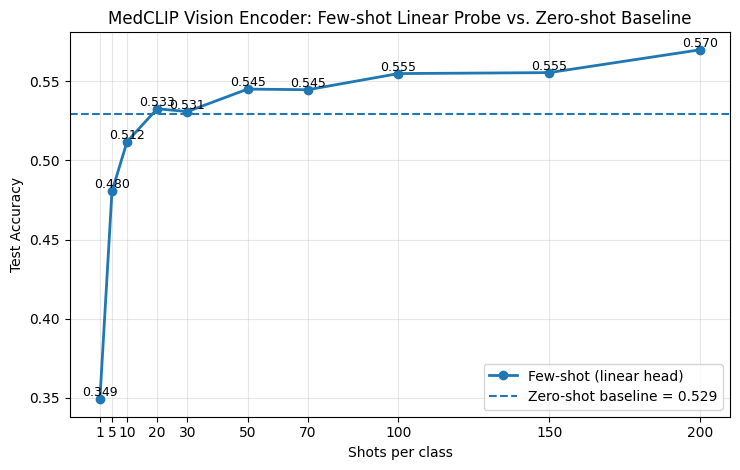

In [9]:
# ========= 7) 绘制折线图（含 zero-shot 基线）=========
plt.figure(figsize=(7.5, 4.8))
plt.plot(acc_df["shots"], acc_df["test_accuracy"], marker="o", linewidth=2, label="Few-shot (linear head)")
plt.axhline(y=BASELINE_ZERO_SHOT, linestyle="--", linewidth=1.5, label=f"Zero-shot baseline = {BASELINE_ZERO_SHOT:.3f}")
for x, y in zip(acc_df["shots"], acc_df["test_accuracy"]):
    if np.isfinite(y):
        plt.text(x, y, f"{y:.3f}", ha="center", va="bottom", fontsize=9)
plt.xlabel("Shots per class")
plt.ylabel("Test Accuracy")
plt.title("MedCLIP Vision Encoder: Few-shot Linear Probe vs. Zero-shot Baseline")
plt.xticks(acc_df["shots"])
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()